In [ ]:
!pip install datasets
!pip install evaluate
!pip install seqeval

In [ ]:
import pandas as pd
import ast
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizerFast, BertForTokenClassification, TrainingArguments, Trainer
import evaluate

In [ ]:
# Step 1: Load the Dataset
file_path = "formatted_bio_data.xlsx"
data = pd.read_excel(file_path)

# Step 2: Convert String Representations to Lists
data["tokens"] = data["tokens"].apply(ast.literal_eval)
data["labels"] = data["labels"].apply(ast.literal_eval)

# Step 3: Ensure Token-Label Alignment
data["valid"] = data.apply(lambda row: len(row["tokens"]) == len(row["labels"]), axis=1)
invalid_rows = data[~data["valid"]]
if len(invalid_rows) > 0:
    print(f"Warning: Dropping {len(invalid_rows)} invalid rows where tokens and labels do not align.")
data = data[data["valid"]].drop(columns=["valid"])

In [ ]:
data

,text_id,tokens,labels
0,1,"[abacavir, adalah, obat, antivirus, yang, digu...","[B-nama_obat, O, O, O, O, O, O, O, O, B-indika..."
1,2,"[abemaciclib, adalah, obat, kemoterapi, untuk,...","[B-nama_obat, O, O, O, O, O, B-indikasi_obat, ..."
2,3,"[abrocitinib, adalah, obat, untuk, mengatasi, ...","[B-nama_obat, O, O, O, O, B-indikasi_obat, I-i..."
3,4,"[acalabrutinib, adalah, obat, kemoterapi, untu...","[B-nama_obat, O, O, O, O, O, B-indikasi_obat, ..."
4,5,"[acarbose, adalah, obat, untuk, menurunkan, ka...","[B-nama_obat, O, O, O, B-indikasi_obat, I-indi..."
...,...,...,...
1559,1560,"[zoledronic, acid, adalah, obat, untuk, mengat...","[B-nama_obat, I-nama_obat, O, O, O, B-indikasi..."
1560,1561,"[zonisamide, adalah, obat, untuk, mengatasi, k...","[B-nama_obat, O, O, O, O, B-indikasi_obat, I-i..."
1561,1562,"[zoralin, adalah, tablet, antijamur, berbahan,...","[B-nama_obat, O, O, B-indikasi_obat, O, O, O, ..."
1562,1563,"[zovigen, adalah, obat, oles, yang, bermanfaat...","[B-nama_obat, O, O, O, O, O, O, O, B-indikasi_..."


In [ ]:
# Step 4: Map String Labels to Numerical Indices
unique_labels = set(label for sublist in data["labels"] for label in sublist)
label2id = {label: idx for idx, label in enumerate(sorted(unique_labels))}
id2label = {idx: label for label, idx in label2id.items()}
data["labels"] = data["labels"].apply(lambda labels: [label2id[label] for label in labels])

# Step 5: Convert to Hugging Face Dataset Format
dataset = Dataset.from_pandas(data)
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(data, test_size=0.5, random_state=42)
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# Step 6: Load Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [ ]:
# Step 7: Tokenize and Align Labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        padding='max_length', # Change padding to 'max_length'
        is_split_into_words=True,
        max_length=512 # Add max_length argument
    )

    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        # Pad labels to the same length as input_ids
        label_ids = label_ids + [-100] * (len(tokenized_inputs["input_ids"][i]) - len(label_ids))
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

train_dataset = train_dataset.map(tokenize_and_align_labels, batched=True)
val_dataset = val_dataset.map(tokenize_and_align_labels, batched=True)
test_dataset = test_dataset.map(tokenize_and_align_labels, batched=True)

# Step 8: Load Model
num_labels = len(label2id)
model = BertForTokenClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.1",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

Map:   0%|          | 0/1251 [00:00<?, ? examples/s]

Map:   0%|          | 0/782 [00:00<?, ? examples/s]

Map:   0%|          | 0/782 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Step 9: Define Metrics
metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=2)

    true_labels = [
        [id2label[label] for label in label_row if label != -100]
        for label_row in labels
    ]
    true_predictions = [
        [id2label[pred] for pred, label in zip(pred_row, label_row) if label != -100]
        for pred_row, label_row in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [ ]:
# Step 10: Training Arguments
training_args = TrainingArguments(
    output_dir="./ner_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    report_to="none"
)

# Step 11: Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Step 12: Train the Model
trainer.train()

# Step 13: Save the Model
trainer.save_model("./ner_model")
tokenizer.save_pretrained("./ner_model")

print("Training complete! Model saved to ./ner_model.")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-37d7ea862688>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.385500,0.345082,0.668435,0.788821,0.723655,0.876621
2,0.314000,0.273528,0.737779,0.837031,0.784277,0.905408
3,0.262200,0.252836,0.749438,0.842192,0.793112,0.911367


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training complete! Model saved to ./ner_model.


Extracting predictions...



Generating confusion matrix...


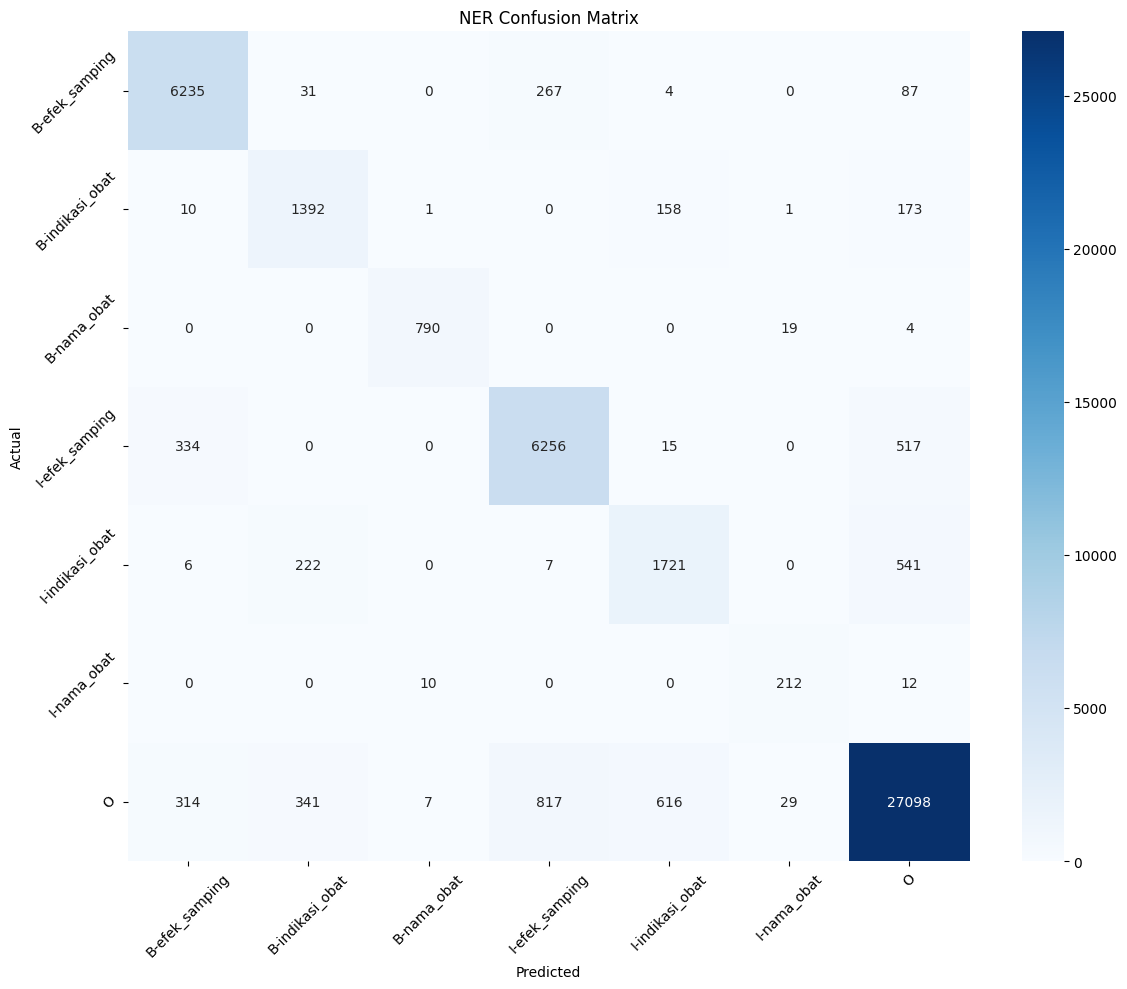


Analyzing errors...

Classification Report:
                 precision    recall  f1-score   support

 B-efek_samping       0.90      0.94      0.92      6624
B-indikasi_obat       0.70      0.80      0.75      1735
    B-nama_obat       0.98      0.97      0.97       813
 I-efek_samping       0.85      0.88      0.86      7122
I-indikasi_obat       0.68      0.69      0.69      2497
    I-nama_obat       0.81      0.91      0.86       234
              O       0.95      0.93      0.94     29222

       accuracy                           0.91     48247
      macro avg       0.84      0.87      0.86     48247
   weighted avg       0.91      0.91      0.91     48247


Detailed error analysis has been saved to 'ner_error_analysis_detailed.xlsx'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple

def extract_ner_predictions(model, tokenizer, test_dataset, id2label):
    """Extract NER predictions from the model"""
    predictions = []
    actuals = []

    # Get predictions from the model
    raw_predictions = trainer.predict(test_dataset)
    pred_logits = raw_predictions.predictions
    pred_labels = np.argmax(pred_logits, axis=2)

    # Convert predictions to labels
    for pred_label_ids, input_ids, label_ids in zip(
        pred_labels,
        test_dataset['input_ids'],
        test_dataset['labels']
    ):
        pred_tokens = []
        true_tokens = []

        # Convert IDs back to tokens and labels
        for pred_id, input_id, true_id in zip(pred_label_ids, input_ids, label_ids):
            if true_id != -100:  # Skip special tokens
                pred_tokens.append(id2label[pred_id])
                true_tokens.append(id2label[true_id])

        predictions.append(pred_tokens)
        actuals.append(true_tokens)

    return predictions, actuals

def create_confusion_matrix(y_true: List[str], y_pred: List[str], labels: List[str]):
    """Create and plot confusion matrix"""
    # Flatten the lists since they might be nested
    y_true_flat = [item for sublist in y_true for item in sublist]
    y_pred_flat = [item for sublist in y_pred for item in sublist]

    # Create confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('NER Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return cm

def get_sentence_context(tokens: List[str], error_index: int, window_size: int = 5) -> str:
    """Get the surrounding context of a token in error"""
    start = max(0, error_index - window_size)
    end = min(len(tokens), error_index + window_size + 1)
    context = tokens[start:end]
    return ' '.join(context)

def analyze_errors(predictions: List[List[str]],
                  actuals: List[List[str]],
                  tokens: List[List[str]]) -> pd.DataFrame:
    """Analyze prediction errors and create detailed comparison"""
    error_analysis = []

    for sent_idx, (pred_seq, true_seq, token_seq) in enumerate(zip(predictions, actuals, tokens)):
        # Find the drug name in the sentence (assuming it starts with B-nama_obat)
        drug_name = None
        for idx, (label, token) in enumerate(zip(true_seq, token_seq)):
            if label == 'B-nama_obat':
                drug_name = token
                break

        for token_idx, (pred, true, token) in enumerate(zip(pred_seq, true_seq, token_seq)):
            if pred != true:
                context = get_sentence_context(token_seq, token_idx)
                error_analysis.append({
                    'Sentence_Number': sent_idx + 1,
                    'Drug_Name': drug_name if drug_name else 'Not Found',
                    'Error_Position': token_idx + 1,
                    'Token': token,
                    'Predicted': pred,
                    'Actual': true,
                    'Context': context
                })

    error_df = pd.DataFrame(error_analysis)

    # Add additional analysis columns
    error_df['Error_Type'] = error_df.apply(
        lambda x: 'False Negative' if x['Actual'].startswith('B-') or x['Actual'].startswith('I-') else 'False Positive'
        if x['Predicted'].startswith('B-') or x['Predicted'].startswith('I-') else 'Label Mismatch',
        axis=1
    )

    # Sort by sentence number and error position
    error_df = error_df.sort_values(['Sentence_Number', 'Error_Position'])

    return error_df

# Extract predictions
print("Extracting predictions...")
predictions, actuals = extract_ner_predictions(model, tokenizer, test_dataset, id2label)

# Get unique labels (excluding special tokens)
unique_labels = sorted(list(set([label for sublist in actuals for label in sublist])))

# Create confusion matrix
print("\nGenerating confusion matrix...")
cm = create_confusion_matrix(actuals, predictions, unique_labels)

# Analyze errors
print("\nAnalyzing errors...")
error_df = analyze_errors(predictions, actuals, test_dataset['tokens'])

# Calculate error statistics
error_stats = pd.DataFrame({
    'Error_Count': error_df['Error_Type'].value_counts(),
    'Percentage': error_df['Error_Type'].value_counts(normalize=True) * 100
})

# Save error analysis to Excel with multiple sheets
with pd.ExcelWriter('ner_error_analysis_detailed_bio_bio.xlsx') as writer:
    error_df.to_excel(writer, sheet_name='Detailed_Errors', index=False)
    error_stats.to_excel(writer, sheet_name='Error_Statistics')

    # Create pivot table for error patterns
    error_patterns = pd.pivot_table(
        error_df,
        values='Token',
        index=['Actual'],
        columns=['Predicted'],
        aggfunc='count',
        fill_value=0
    )
    error_patterns.to_excel(writer, sheet_name='Error_Patterns')

print("\nClassification Report:")
flat_predictions = [item for sublist in predictions for item in sublist]
flat_actuals = [item for sublist in actuals for item in sublist]
print(classification_report(flat_actuals, flat_predictions))

print("\nDetailed error analysis has been saved to 'ner_error_analysis_detailed.xlsx'")

<ipython-input-14-a195de5e279e>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(penyakit_top5.values()), y=list(penyakit_top5.keys()), palette='Blues_d')
<ipython-input-14-a195de5e279e>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(efek_samping_top5.values()), y=list(efek_samping_top5.keys()), palette='Reds_d')


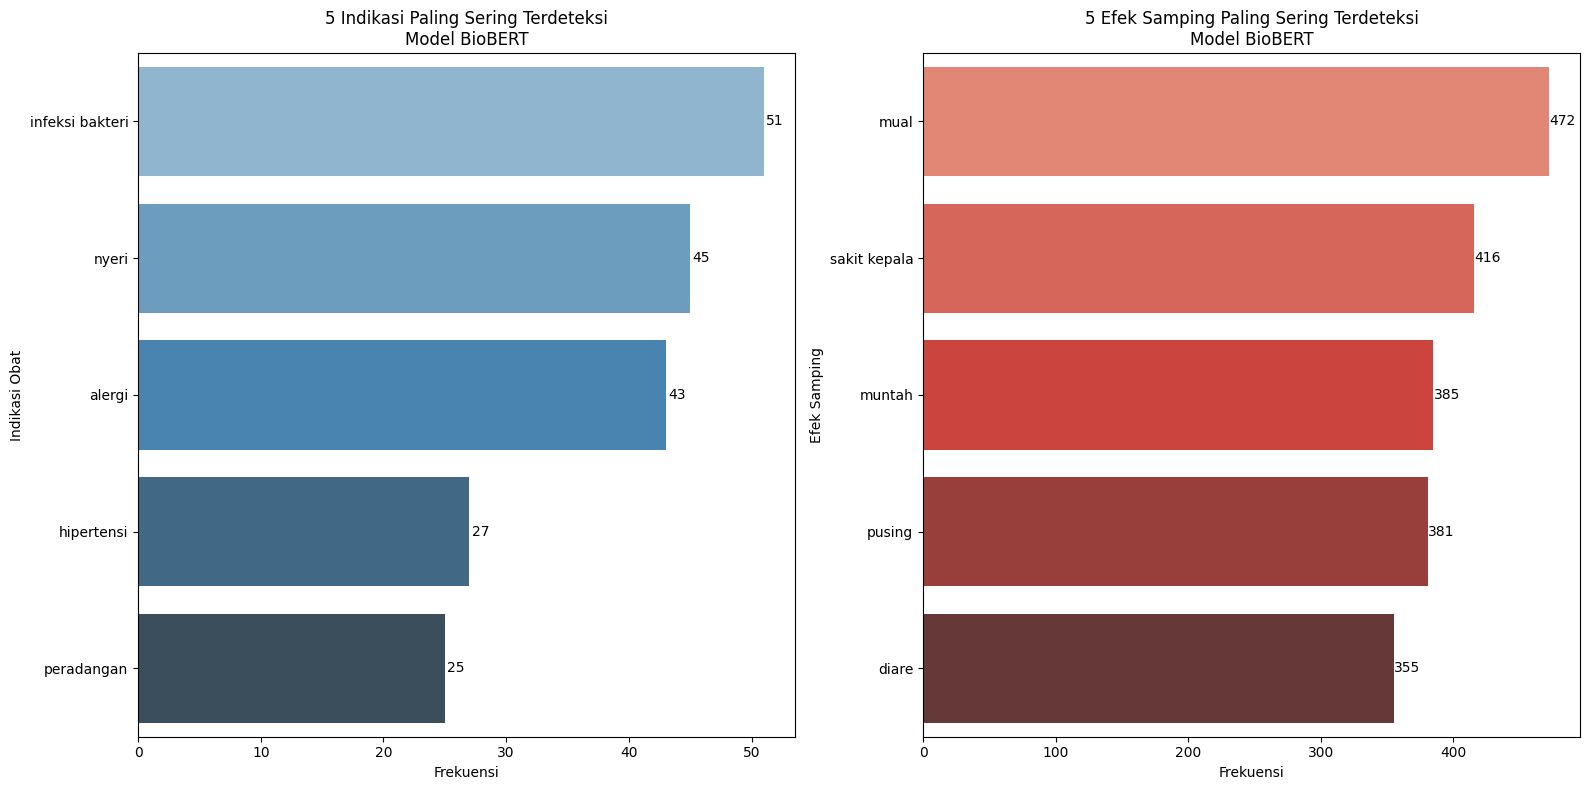

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def extract_predicted_entities(predictions, tokens, label_prefix):
    entities = []

    for pred_seq, token_seq in zip(predictions, tokens):
        current_entity = []

        for pred, token in zip(pred_seq, token_seq):
            # Start of an entity
            if pred == label_prefix:
                current_entity = [token]

            # Continuation of an entity
            elif pred.startswith('I-') and current_entity and pred.split('-')[1] == label_prefix.split('-')[1]:
                current_entity.append(token)

            # Entity ended or new entity starts
            else:
                if current_entity:
                    entities.append(" ".join(current_entity))
                    current_entity = []

        # Handle last entity in sequence
        if current_entity:
            entities.append(" ".join(current_entity))

    return entities

# Extract Penyakit and Efek Samping based on Predicted labels
penyakit_entities = extract_predicted_entities(predictions, test_dataset['tokens'], "B-indikasi_obat")
efek_samping_entities = extract_predicted_entities(predictions, test_dataset['tokens'], "B-efek_samping")

# Count the frequency of each entity
penyakit_counts = Counter(penyakit_entities)
efek_samping_counts = Counter(efek_samping_entities)

# Get the top 5 entities for Penyakit and Efek Samping
penyakit_top5 = dict(penyakit_counts.most_common(5))
efek_samping_top5 = dict(efek_samping_counts.most_common(5))

# Create figure with two subplots
plt.figure(figsize=(16, 8))

# Plot Penyakit
plt.subplot(1, 2, 1)
sns.barplot(x=list(penyakit_top5.values()), y=list(penyakit_top5.keys()), palette='Blues_d')

# Add the frequency values (numbers) on top of each bar
for i, value in enumerate(penyakit_top5.values()):
    plt.text(value + 0.2, i, str(value), va='center', fontsize=10)

plt.title('5 Indikasi Paling Sering Terdeteksi\nModel BioBERT', fontsize=12)
plt.xlabel('Frekuensi', fontsize=10)
plt.ylabel('Indikasi Obat', fontsize=10)

# Plot Efek Samping
plt.subplot(1, 2, 2)
sns.barplot(x=list(efek_samping_top5.values()), y=list(efek_samping_top5.keys()), palette='Reds_d')

# Add the frequency values (numbers) on top of each bar
for i, value in enumerate(efek_samping_top5.values()):
    plt.text(value + 0.2, i, str(value), va='center', fontsize=10)

plt.title('5 Efek Samping Paling Sering Terdeteksi\nModel BioBERT', fontsize=12)
plt.xlabel('Frekuensi', fontsize=10)
plt.ylabel('Efek Samping', fontsize=10)

plt.tight_layout()
plt.show()
